In [1]:
import numpy as np
import collections
from torch.utils import data

import sys
sys.path.append('.')
sys.path.append('../')

from einops import rearrange

import torch
import torch.nn as nn
from torch.nn import functional as FeatureAlphaDropout
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from scipy import io as scipyio
import skimage
import skvideo.io
from utils import print_full

import os
import glob
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

In [2]:
from utils import set_seed
set_seed(25)

In [3]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

train_path = parent_path + "/data/OneCombo3/stimuli/"
video_stack = [skimage.io.imread(vid) for vid in glob.glob(train_path + '/*.tif')][::-1]
print(glob.glob(train_path + '/*.tif')[::-1])
video_stack = np.concatenate(video_stack, axis=0, dtype=np.float32)

# video_stack = skimage.io.imread("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif")
# video_stack = image_dataset(video_stack)
# video_stack = video_stack[::3]  # convert from 60 to 20 fps
# video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])
# video_stack = video_stack.transpose(-1, -2)

# rearrange(video_stack[0, 0:2].transpose(0,1), 'c t (h p1) (w p2) -> (t h w) (p1 p2 c)', p1=16, p2=16).shape

['/home/antonis/projects/slab/git/slab/transformer_exp/code//data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code//data/OneCombo3/stimuli/Combined Stimuli 3-Movie2.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code//data/OneCombo3/stimuli/Combined Stimuli 3-Movie3.tif']
im_sack size: torch.Size([5760, 1, 64, 112])


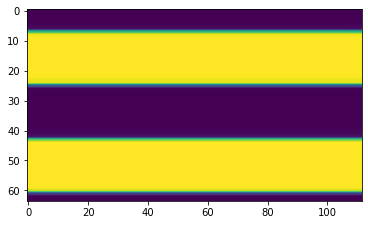

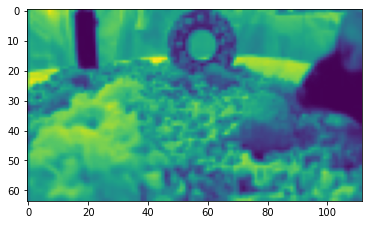

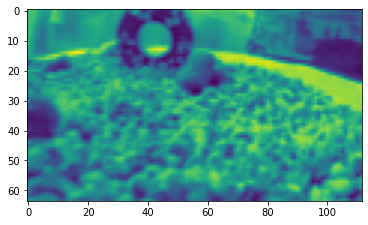

In [4]:
plt.figure()
plt.imshow(video_stack[0, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[1, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[2, 1].permute(1, 2, 0))

In [5]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat(parent_path + "/data/OneCombo3/spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [6]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.01

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['Interval_dt'] = make_intervals(df, dt)
df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(2)
df = df.reset_index(drop=True)

In [7]:
n_dt = sorted((df['Interval_dt'].unique()).round(3)) # add last interval for EOS'

df['Time'] = df['Time'].round(3)

In [8]:
from SpikeVidUtils import SpikeTimeVidData

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
frame_feats = video_stack.transpose(1, 2)

frame_block_size = 560
prev_id_block_size = 30
id_block_size = 30 * 2    # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
# pixels = sorted(np.unique(frames).tolist())
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.5

In [9]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
for n_stim in range(3):
    n_trial = [15, 5]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [10]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=True)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
# small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=True)


print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

Length: 23138 Neurons: 168 Pixels: 0.
id block size: 60
frames: 560, id: 60
Length: 2474 Neurons: 168 Pixels: 0.
id block size: 60
frames: 560, id: 60
train: 3312, test: 358


In [11]:
# def get_class_weights(df, population_size):
#     class_freq = df.groupby(['ID']).size().nlargest(2)
#     class_freq_pad = np.array(class_freq.tolist() + [class_freq.max()]*(population_size - len(class_freq)), dtype=np.float32)
#     return torch.tensor(np.reciprocal(class_freq_pad) * class_freq.max(), dtype=torch.float32) / class_freq.max()

def get_class_weights(df, population_size):
    len_data = len(train_data.drop_duplicates(subset=['Interval', 'Trial'])[['Interval', 'Trial']])
    id_freq = [len(df[df['ID'] == id]) for id in range(neurons[-1] + 1)]
    sos_freq = [len_data * 2]
    eos_freq = [len_data * 1]
    pad_freq = [(len_data * (id_block_size + prev_id_block_size)) - len(df)]
    class_freq = np.array(id_freq + sos_freq + eos_freq + pad_freq, dtype=np.float32)
    class_freq = torch.tensor(np.reciprocal(class_freq) * class_freq.max(), dtype=torch.float32) / class_freq.max()
    return torch.nan_to_num(class_freq, 1)

class_weights = get_class_weights(df, train_dataset.id_population_size)

/tmp/ipykernel_8239/156052261.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  class_freq = torch.tensor(np.reciprocal(class_freq) * class_freq.max(), dtype=torch.float32) / class_freq.max()


In [79]:
from model_perceiver import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=class_weights,
                        pretrain=True,
                        n_layer=8, n_head=4, n_embd=256,
                        temp_emb=True, pos_emb=True,
                        id_drop=0.2, im_drop=0.2)
model = GPT(mconf)
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-08-21-00:35-e:211-b:272-l:5-h:2-ne:512-higher_order.pt"))

In [98]:
""" Predict using TEST dataset """

from utils import predict_raster, predict_raster_resnet, predict_raster_enc_dec, predict_raster_recursive, predict_beam_search, predict_raster_recursive_time, predict_beam_search_time, predict_raster_hungarian
%matplotlib inline

loader = DataLoader(test_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)

# device = torch.cuda.current_device()
# model = model.to(device)
model.load_state_dict(torch.load(parent_path +  "/transformer_vid3/runs/models/12-14-21-23:44-e:17-b:650-l:8-h:4-ne:256-higher_order.pt"))

""" 

To predict only neurons we pass <frame_end> so we see predictions only for Neurons 
If you want to also see frame_tokens, just pass <frame_end=0>

NOTE: 512 ID is the <end-of-sequence-id>. Right now, makes no difference if I include
it in loss, here it is included in loss and predictions.

"""
# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted = predict_raster(model, loader)

# true, predicted = predict_beam_search(model, loader, stoi)
true, predicted, true_timing = predict_raster_recursive(model, loader, stoi, sample=True, top_k=15, gpu=True, frame_end=frame_block_size, get_dt=True)
# true, predicted = predict_raster_hungarian(model, loader)
# true, predicted, true_timing = predict_raster(model, loader, gpu=True, frame_end=frame_block_size, get_dt=True)

true_df = pd.DataFrame(true.numpy())
predicted_df = pd.DataFrame(predicted.numpy())
print(len(true_df[true_df[0] == 512]), len(predicted_df[predicted_df[0] == 512])) 

100%|██████████| 358/358 [00:25<00:00, 14.24it/s]

0 0


In [99]:
df_pred = pd.DataFrame({'True':true, 'Predicted':predicted, 'Time':true_timing})    # Time':test_data['Time']})

0
0      13
1      51
2      68
3      11
4      58
       ..
160    13
161    18
162    26
163    32
164    18
Length: 162, dtype: int64


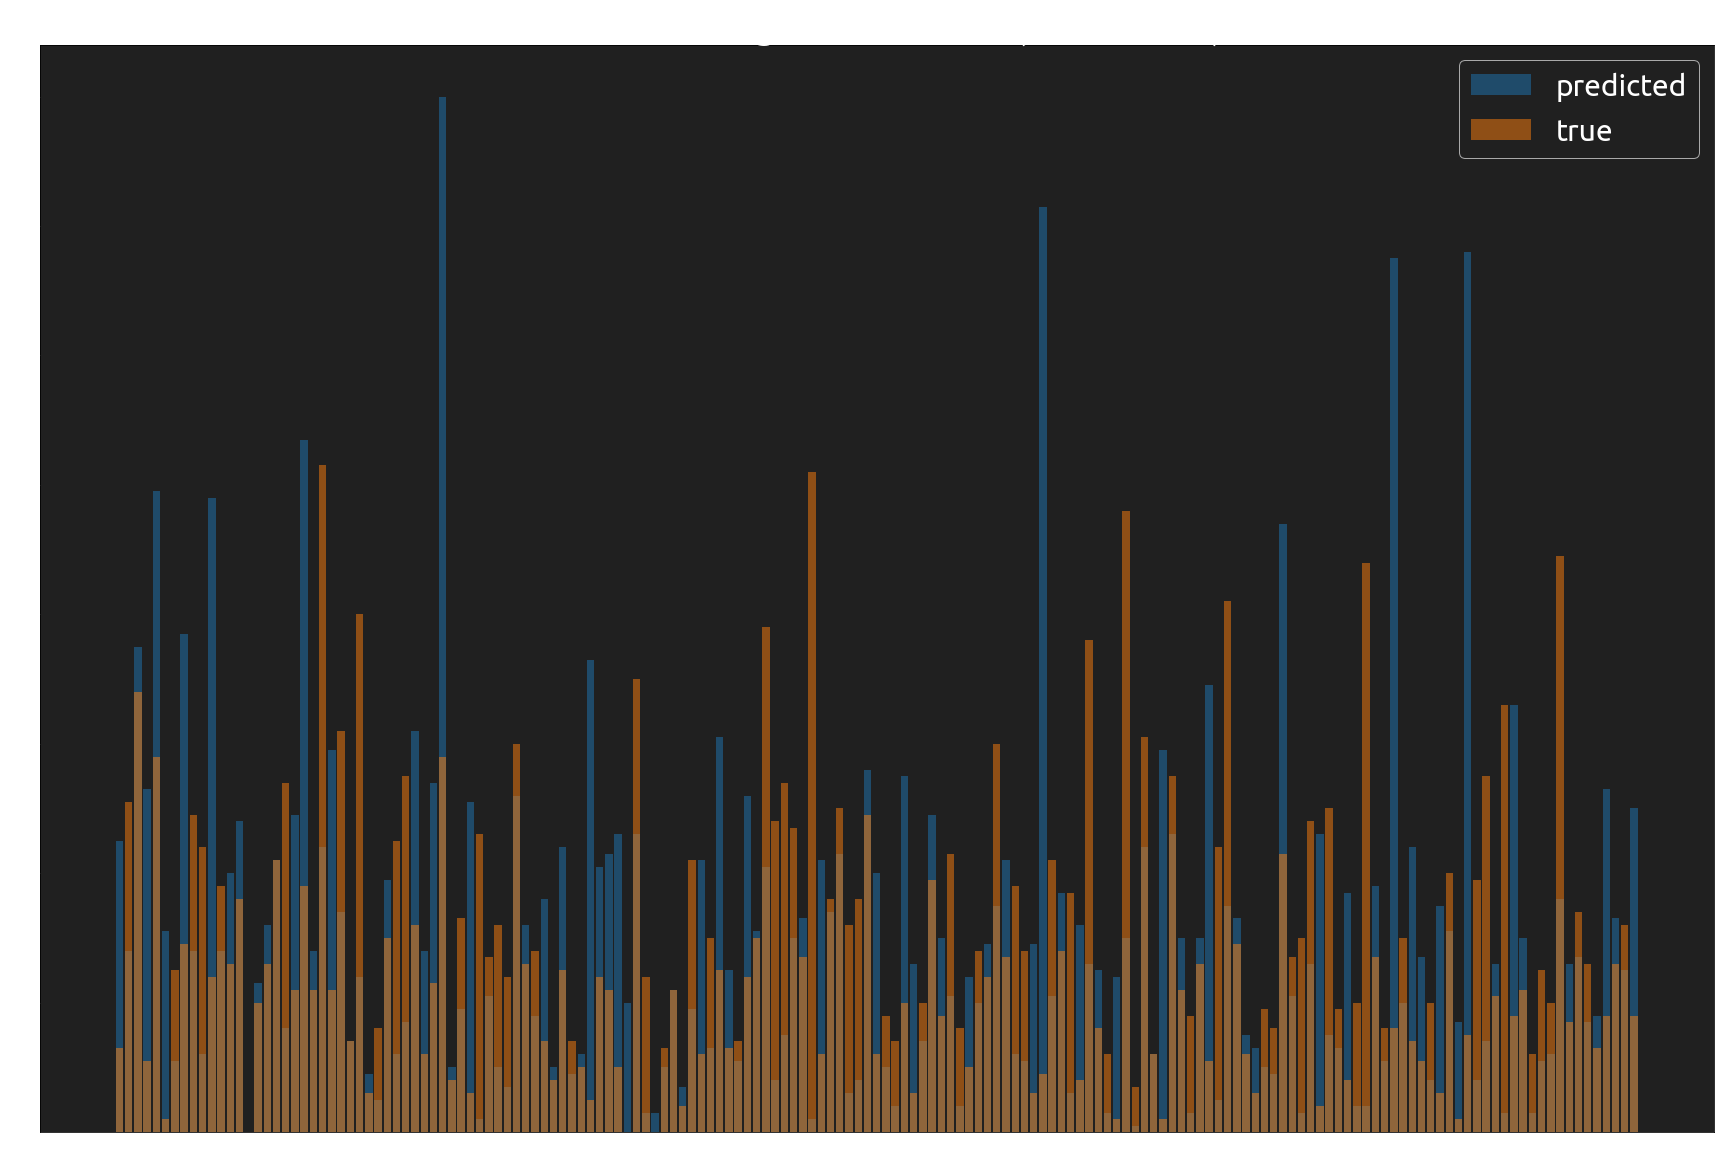

In [101]:
def plot_this(true_df, predicted_df):
    plt.figure(figsize=(30,20))
    n_min = 165
    freq_true = true_df[true_df[0] < n_min].groupby([0]).size()
    print(freq_true)
    freq_pred = predicted_df[predicted_df[0] < n_min].groupby([0]).size()
    plt.bar(freq_pred.index, freq_pred, label='predicted', alpha=0.5)
    plt.bar(freq_true.index, freq_true, label='true', alpha=0.5)
    plt.title('Neuron Firing Distribution (PSTH Loss)', fontsize=40)
    plt.legend(fontsize=30)
    plt.show()

plot_this(pd.DataFrame(true.numpy()), pd.DataFrame(predicted.numpy()))

In [102]:
labels = [round(window + window*n, 2) for n in range(0, int(max(df_pred['Time']) / window))]

def group_intervals(df, dt):
    window = dt
    bins = int(max(df['Time']) / window)
    intervals = pd.cut(df['Time'], bins=int(max(df['Time']) / window))
    labels = [round(window + window*n, 2) for n in range(0, int(max(df['Time']) / window))]
    indexes = [n for n in range(0, int(max(df['Time']) / window))]
    df['Interval'] = pd.cut(df['Time'], bins=int(max(df['Time']) / window), labels=labels).astype('float32')
    df['Interval_idx'] = pd.cut(df['Time'], bins=int(max(df['Time']) / window), labels=indexes)
    df = df.reset_index().drop(['index'], axis=1)
    return df

df_pred = group_intervals(df_pred, window)

In [103]:
def get_rates(df, intervals):
    df_true = df.groupby(['True', 'Interval']).count().unstack(fill_value=0).stack()['Predicted']
    df_pred = df.groupby(['Predicted', 'Interval']).count().unstack(fill_value=0).stack()['True']
    def set_rates(df, id, intervals):
        df = df[id]
        rates = np.zeros_like(intervals)
        for i in df.index:
            n = int((i * 2) - 1)
            rates[n] = df[i]            
        return rates
    rates_true = dict()
    rates_pred = dict()
    for id in list(set(df['True'].unique()) & set(df['Predicted'].unique())):
        rates_true[id] = set_rates(df_true, id, intervals)
        rates_pred[id] = set_rates(df_pred, id, intervals)
    return rates_true, rates_pred

In [104]:
from scipy import stats
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from scipy.special import kl_div

rates_true, rates_pred = get_rates(df_pred, labels)

def calc_corr_psth(rates1, rates2):
    pearson_r = dict()
    for id in list((set(rates1.keys()) & set(rates2.keys()))):
        pearson_r[id] = stats.pearsonr(rates1[id], rates2[id])[0]
    # pearson_r = dict(sorted(pearson_r.items(), reverse=True, key=lambda item: item[1]))
    pearson_r = pd.DataFrame(pearson_r, index=['pearson_r']).T.sort_values(by=['pearson_r'], ascending=False)
    return pearson_r


top_corr = calc_corr_psth(rates_true, rates_pred)

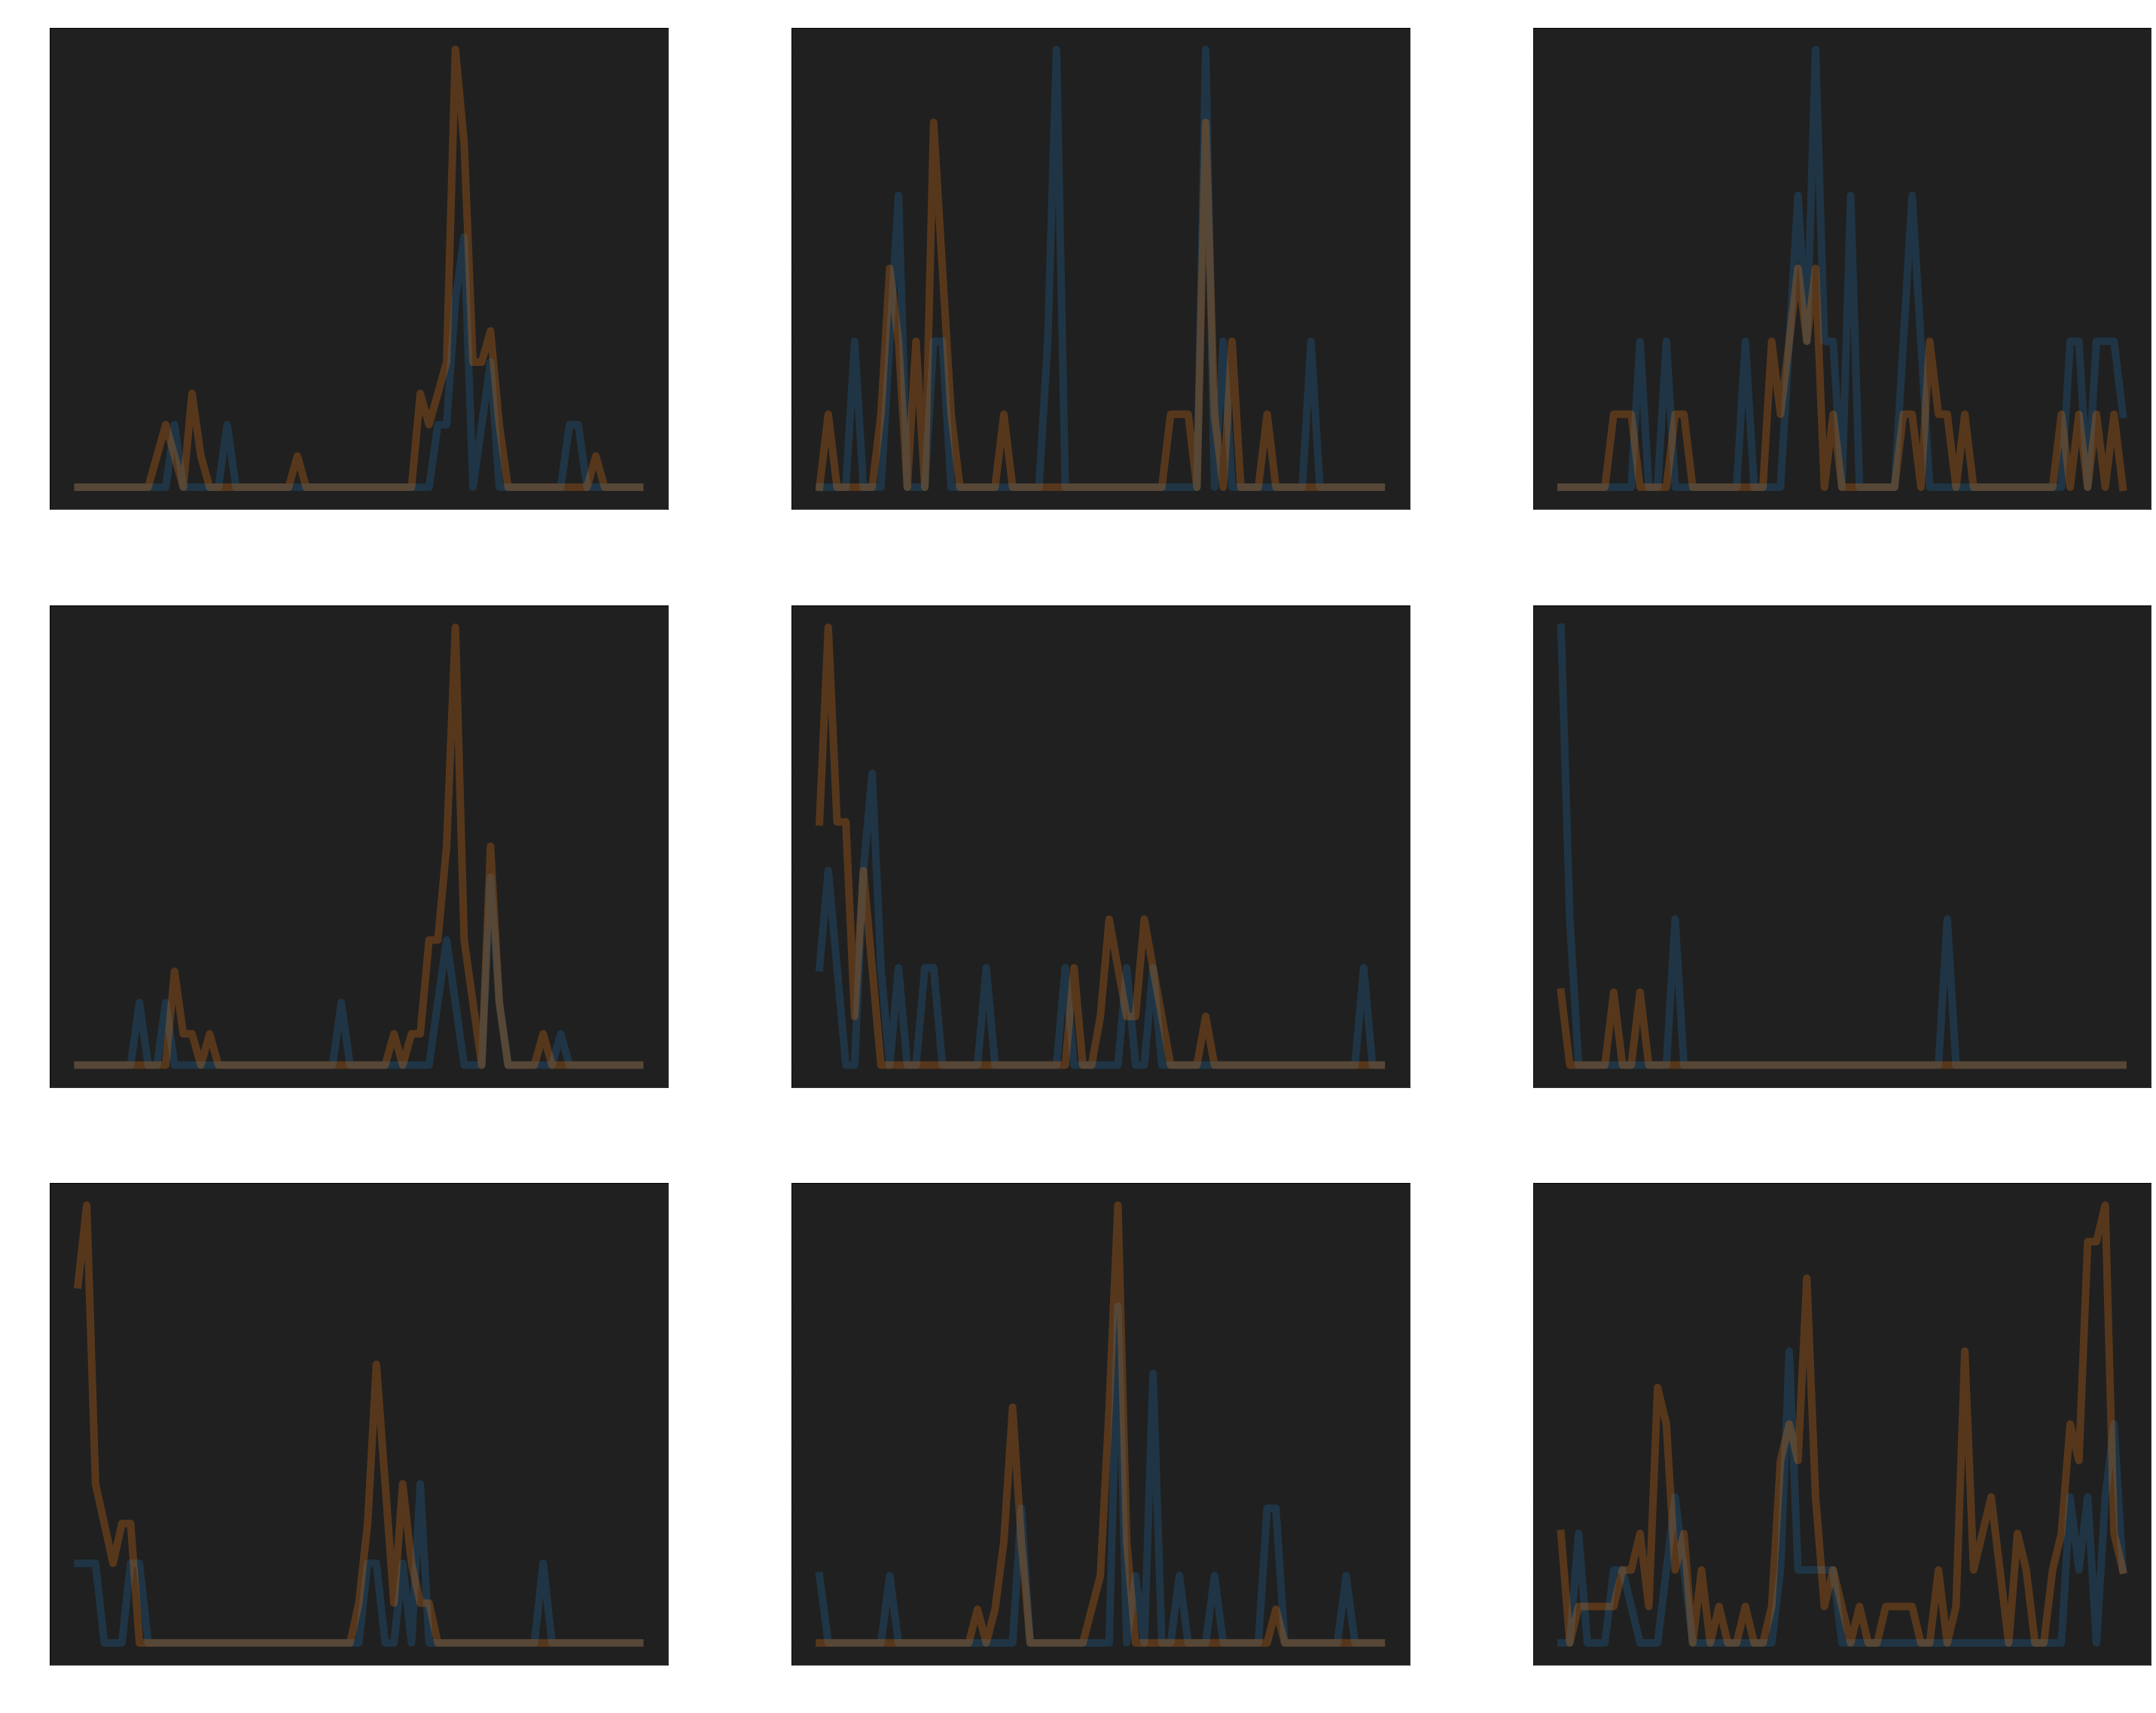

In [105]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelpad'] = 15

cols = 3
rows = 3
plt.figure(figsize=(50, 40))
plt.title('Neuron Firings', size=20)
gs = plt.GridSpec(cols, rows)
for n, id in enumerate(top_corr.index[:cols*rows]):
    i = n % cols
    j = n // cols
    plt.subplot(gs[i, j])
    plt.plot(labels, rates_true[id], alpha=0.25, label='true', linewidth=10)
    plt.plot(labels, rates_pred[id], alpha=0.25, label='predicted', linewidth=10)
    plt.title(f'ID {id}', size=30)
    plt.ylabel('Frequency', size=20)
    plt.xlabel('Time (s)', size=20)

In [106]:
def get_rates_trial(df, intervals):
    df_rates = df.groupby(['ID', 'Interval']).count().unstack(fill_value=0).stack()
    def set_rates(df, id, intervals):
        df = df.loc[id]
        rates = np.zeros_like(intervals)
        for i in df.index:
            n = int((i * 2) - 2)
            rates[n] = df['Time'].loc[i] 
        return rates
    rates = dict()
    for id in list(set(df['ID'].unique())):
        rates_id = set_rates(df_rates, id, intervals)
        rates[id] = rates_id
    return rates

In [111]:
t_1 = 25
t_2 = 35

rates_trial_8 = get_rates_trial(df[df['Trial'] == t_1].reset_index(drop=True), labels)
rates_trial_1 = get_rates_trial(df[df['Trial'] == t_2].reset_index(drop=True), labels)
corr_trials = calc_corr_psth(rates_trial_1, rates_trial_8)

# neuron_list = [5 * n for n in range(10)]
# neuron_list = [5 * n for n in range(10)]
# neuron_list = df_pred.groupby(['True']).size().nlargest(20).index.tolist()
neuron_list = top_corr[:20].index.tolist()

df_pred_8_true = df_pred.iloc[test_data[test_data['Trial'] == t_1].index.tolist()][df_pred['True'].isin(neuron_list)]
df_pred_8_pred = df_pred.iloc[test_data[test_data['Trial'] == t_1].index.tolist()][df_pred['Predicted'].isin(neuron_list)]
df_pred_7_true = df_pred.iloc[test_data[test_data['Trial'] == t_2].index.tolist()][df_pred['True'].isin(neuron_list)]

df_pred_8_true['Time'] -= df_pred_8_true['Time'].max()
df_pred_8_pred['Time'] -= df_pred_8_pred['Time'].max()
df_pred_7_true['Time'] -= df_pred_7_true['Time'].max()

df_pred_8_true_= pd.melt(df_pred_8_true, id_vars='Time', value_vars=['True']).dropna()
df_pred_8_pred_= pd.melt(df_pred_8_pred, id_vars='Time', value_vars=['Predicted']).dropna()
df_pred_7_true_ = pd.melt(df_pred_7_true, id_vars='Time', value_vars=['True']).dropna()

/tmp/ipykernel_8239/2663529807.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pred_8_true = df_pred.iloc[test_data[test_data['Trial'] == t_1].index.tolist()][df_pred['True'].isin(neuron_list)]
/tmp/ipykernel_8239/2663529807.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pred_8_pred = df_pred.iloc[test_data[test_data['Trial'] == t_1].index.tolist()][df_pred['Predicted'].isin(neuron_list)]
/tmp/ipykernel_8239/2663529807.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pred_7_true = df_pred.iloc[test_data[test_data['Trial'] == t_2].index.tolist()][df_pred['True'].isin(neuron_list)]


In [112]:
def get_spikes(df_pred, df, trial, neuron_list, labels):
    rates_trial = get_rates_trial(get_rates_trial(df[df['Trial'] == trial].reset_index(drop=True), labels))
    df_pred_true = df_pred.iloc[test_data[test_data['Trial'] == trial].index.tolist()][df_pred['True'].isin(neuron_list)]
    df_pred_pred = df_pred.iloc[test_data[test_data['Trial'] == trial].index.tolist()][df_pred['Predicted'].isin(neuron_list)]
    return df_pred_true, df_pred_pred


In [113]:
spacing = np.arange(0, 250, step=250/len(neuron_list))
for ix, neuron in enumerate(df_pred_8_true['True'].unique()):
    df_pred_8_true['True'][df_pred_8_true['True'] == neuron] = spacing[ix]
    df_pred_8_pred['Predicted'][df_pred_8_pred['Predicted'] == neuron] = spacing[ix]
    df_pred_7_true['True'][df_pred_7_true['True'] == neuron] = spacing[ix]

/tmp/ipykernel_8239/3125398011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_8_true['True'][df_pred_8_true['True'] == neuron] = spacing[ix]
/tmp/ipykernel_8239/3125398011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_8_pred['Predicted'][df_pred_8_pred['Predicted'] == neuron] = spacing[ix]
/tmp/ipykernel_8239/3125398011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_7_true['True'][df_pred_7_true[

Text(0.5, 0, 'Time (s)')

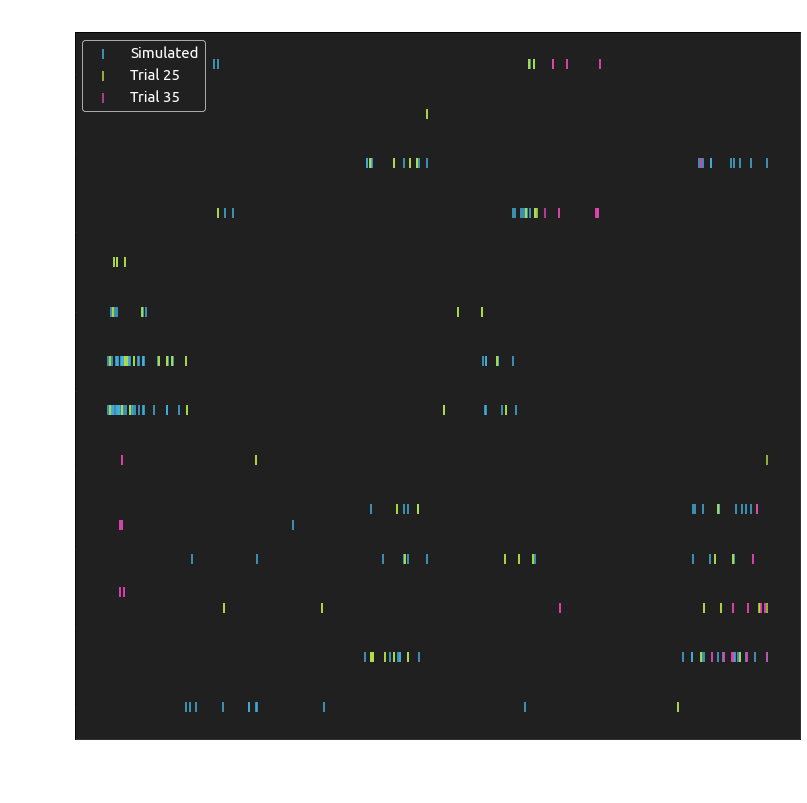

In [114]:
plt.figure(figsize=(13, 13))

plt.scatter(df_pred_8_pred['Time'], df_pred_8_pred['Predicted'], color='#45b3e0', marker="|", s=100, label='Simulated')
plt.scatter(df_pred_8_true['Time'], df_pred_8_true['True'] + 0, color='#b3e045', marker="|", s=100, label=f'Trial {t_1}')
plt.scatter(df_pred_7_true['Time'], df_pred_7_true['True'] - 0, color='#e045b3', marker="|", s=100, label=f'Trial {t_2}')

# plt.yticks(np.arange(0, len(neuron_list), step=160 / len(neuron_list)))
plt.legend(loc=2, fontsize=15, title_fontsize=15)
plt.title('Spike Raster', fontsize=25)
plt.ylabel('Neuron ID', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

# some random data
x = np.random.randn(1000)
y = np.random.randn(1000)


def scatter_hist(x, y, ax, ax_histy):
    # no labels
    # ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    # ax.scatter(x, y)
    # bins = 250

    # now determine nice limits by hand:
    # binwidth = 0.25
    # xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    # lim = (int(xymax/binwidth) + 1) * binwidth

    # bins = np.arange(-lim, lim + binwidth, binwidth)
    # ax_histx.hist(x, bins=bins)
    ax_hist = sns.distplot(y,  hist=False, ax=ax_histy, vertical=True) # (x, y, bins=10, orientation='horizontal')
    ax_hist.set(xlabel=None)

    # sns.distplot(top_corr, hist=False, ax=ax_histy, vertical=True)


/home/antonis/anaconda3/envs/transformer_exp/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antonis/anaconda3/envs/transformer_exp/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/home/antonis/anaconda3/envs/transformer_exp/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level func

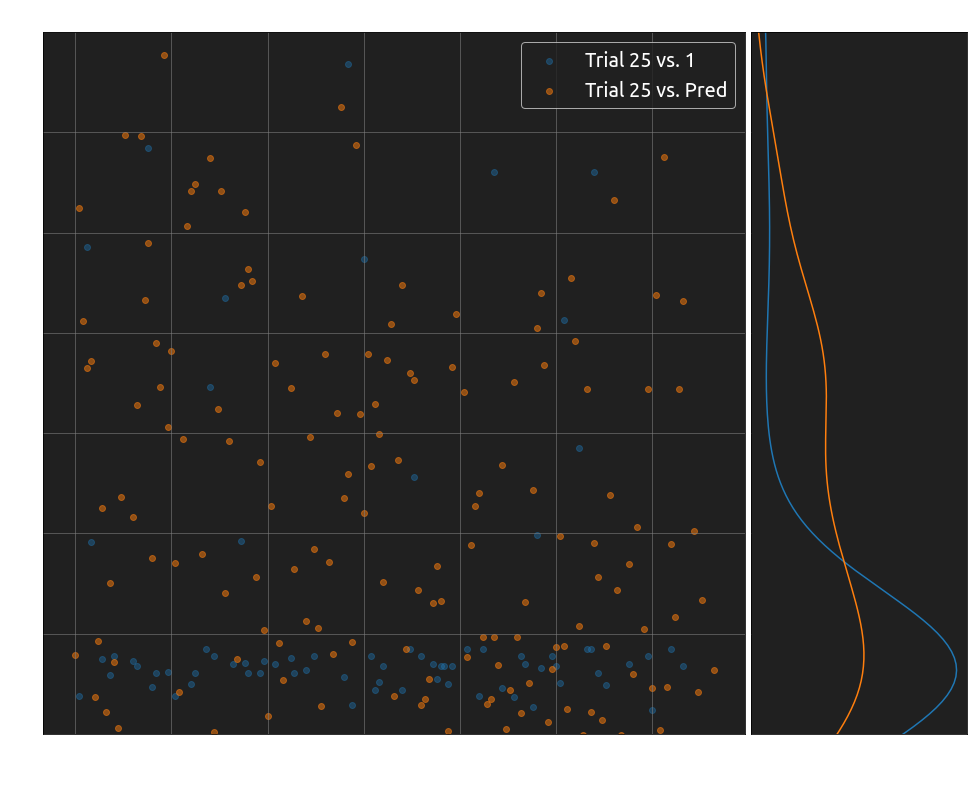

In [119]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(15, 15))

ax = fig.add_axes(rect_scatter)
# ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(np.array(corr_trials.index), corr_trials, ax, ax_histy)
scatter_hist(np.array(top_corr.index), top_corr, ax, ax_histy)
ax.grid(lw=0.8, alpha=0.7, color='gray')
ax.scatter(corr_trials.index, corr_trials, label=f'Trial {t_1} vs. 1', alpha=0.4)
ax.scatter(top_corr.index, top_corr, label=f'Trial {t_1} vs. Pred', alpha=0.5)
ax.set_title('Pair-wise Correlation Between Trials', fontsize=25)
ax.set_xlabel('Neuron ID', fontsize=20)
ax.set_ylim(-0.1, 0.6)
plt.ylabel('Pearson Correlation (p)')
ax.legend(fontsize=20, title_fontsize=20)
plt.show()